Neo4J v058 test1- Data Analysis and Visualizing 
================

## Set up the environment


### Install py2neo for querying Neo4J 

In [52]:
#!pip3 install -U py2neo

# add python path of py2neo in system

#!pip3 install -U neotime
#!pip3 install -U neobolt
#!pip3 install -U xlrd

### Import Packages

In [53]:
from py2neo import Graph

from google.cloud import storage
import yaml

import pandas as pd
import numpy as np
import subprocess
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import google.datalab.bigquery as bq

#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load Neo4J DB

In [21]:
bucket_info=''
credential_info=''

In [54]:
# Option 1 : Read DB and Account Information in Google Storage (YAML)

# create storage client
storage_client = storage.Client()
# get bucket with name
bucket = storage_client.get_bucket(bucket_info)
# get bucket data as blob
blob = bucket.get_blob(credential_info)
# convert to string
yaml_data = blob.download_as_string()

account = yaml.load(yaml_data, Loader=yaml.FullLoader)

## Main Account
graph = Graph(account['NEO4J_SCHEME']+'://'+account['NEO4J_HOST']+":"+str(account['NEO4J_PORT']), auth=(account['NEO4J_USER'],account['NEO4J_PASSPHRASE']))

# v057
#graph = Graph("bolt://10.138.0.73:7687", auth=("neo4j", ""))

# v056
#graph = Graph("bolt://10.138.0.3:7687", auth=("neo4j", ""))

--------
## Merge sample table and job table

### Download BigQuery tables 

In [55]:
#sample_df=pd.read_csv('./sample-based-analysis-v058-1-simple.csv')
#job_df=pd.read_csv('./job-based-analysis-v058-1.csv')

## sample based analysis
bq_sample='gbsc-gcp-project-mvp-test.mvp_wgs35_v058_1.sample_based_analysis'
sample_df = bq.Query('SELECT *' +
                     'FROM `' + bq_sample + '` ').execute().result().to_dataframe()

## job based analysis
bq_job='gbsc-gcp-project-mvp-test.mvp_wgs35_v058_1.job_based_analysis'
job_df = bq.Query('SELECT *' +
                  'FROM `' + bq_job + '` ').execute().result().to_dataframe()

## qc analysis
bq_qc='gbsc-gcp-project-mvp-test.mvp_wgs35_v058_1.qc_analysis'
qc_df = bq.Query('SELECT *' +
                  'FROM `' + bq_qc + '` ').execute().result().to_dataframe()

### Merge pass/fail samples and job table

In [56]:
sample_pass=sample_df[['sample','pass']]
merged_df=pd.merge(sample_pass,job_df,left_on=['sample'],right_on=['sample'],how='right')
merged_df.head(2)

,sample,pass,job_group,job,fq2urg_gatkid,dup,vm_exp_cnt,vm_cnt,vm_avg_runtime,job_runtime,vm_type,vm_cpu,vm_mem,vm_disk,vm_avg_cost,job_cost,dstat_status,dstat_msg,dstat_log
0,SHIP5119453,fail,GATK,FQ2U,3,None,1.00,1,56.00,56.00,custom-2-7680,2,7680,None,0.00,0.09,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...
1,SHIP5119453,fail,GATK,FQ2U,2,None,1.00,1,53.00,53.00,custom-2-7680,2,7680,None,0.00,0.09,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...


In [57]:
num_sample=len(merged_df['sample'].unique())
print('The number of samples : ' + str(num_sample))

The number of samples : 288


---------
## CPU Time

In [58]:
cputime_df=merged_df.loc[(merged_df['pass']=='pass')&(merged_df['job_group']=='GATK'), \
                         ['sample','job','vm_avg_runtime','vm_cpu','vm_exp_cnt','vm_cnt']]

cputime_df['cputime_h']=np.array(cputime_df['vm_cpu'])*np.array(cputime_df['vm_cnt'])*np.array(cputime_df['vm_avg_runtime'])/60

In [59]:
total_cputime=cputime_df.groupby('sample')['cputime_h'].sum().sort_values()

In [60]:
print("Average of total cpu time : " + str(total_cputime.mean()))

Average of total cpu time : 375.0587852852384


/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<function matplotlib.pyplot.show(*args, **kw)>

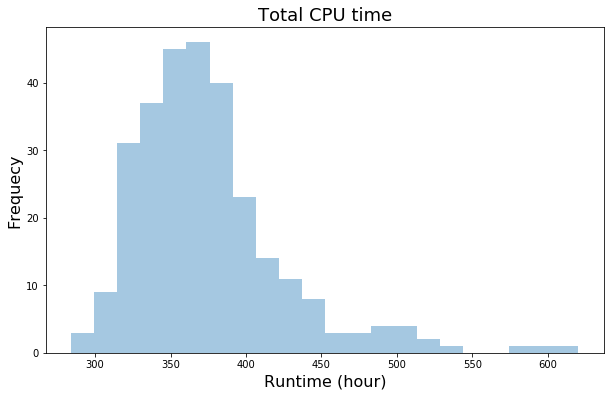

In [61]:
f, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.distplot(total_cputime, kde=False, ax=axes)#.set(xlim=(0,70),ylim=(0,10));
axes.set_title('Total CPU time', fontsize=18)
axes.set_ylabel('Frequecy', fontsize=16)
axes.set_xlabel('Runtime (hour)', fontsize=16)
plt.show

--------
## Duplication Analysis

In [62]:
display(len(sample_df))
sample_df.loc[sample_df['status']=='duplicated jobs',:]

288

,sample,pass,status,dup,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk


### Duplication Count and Percentage (using 'dup' property)

In [63]:
## Total Jobs
num_total_job=merged_df.loc[(merged_df['job']=='FQ2U')|(merged_df['job']=='cromwell'),'job'].value_counts().to_frame()
#display(num_total_job)

## Duplicated Jobs (All, Pass, Fail)
num_dup_job=merged_df.loc[(merged_df['dup']==True)&((merged_df['job']=='FQ2U')|(merged_df['job']=='cromwell')),'job'].value_counts().to_frame()
#display(num_dup_job)

num_dup_job_inpass=merged_df.loc[(merged_df['pass']=='pass')&(merged_df['dup']==True)&((merged_df['job']=='FQ2U')|(merged_df['job']=='cromwell')),'job'].value_counts().to_frame()
#display(num_dup_job_inpass)

num_dup_job_infail=merged_df.loc[(merged_df['pass']=='fail')&(merged_df['dup']==True)&((merged_df['job']=='FQ2U')|(merged_df['job']=='cromwell')),'job'].value_counts().to_frame()
#display(num_dup_job_infail)

### Histogram of duplicated jobs by sample and Runtime

In [64]:
## fq2u duplicated jobs
fq2u_dup=merged_df.loc[(merged_df['dup']==True)&(merged_df['job']=='FQ2U'),['sample','runtime']]
fq2u_dup_bysp=fq2u_dup['sample'].value_counts().to_frame()
fq2u_dup_bysp_freq=fq2u_dup_bysp['sample'].value_counts().to_frame().reset_index()
#display(fq2u_dup_bysp_freq)

## gatk duplicated jobs
gatk_dup=merged_df.loc[(merged_df['dup']==True)&(merged_df['job']=='cromwell'),['sample','runtime']]
gatk_dup_bysp=gatk_dup['sample'].value_counts().to_frame()
gatk_dup_bysp_freq=gatk_dup_bysp['sample'].value_counts().to_frame().reset_index()
#display(gatk_dup_bysp_freq)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


no duplicated fq2u jobs
no duplicated gatk jobs


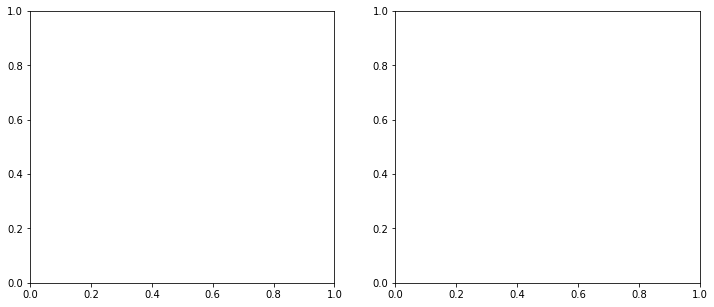

In [65]:
f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

try:
    sns.barplot(x='index', y='sample', data=fq2u_dup_bysp_freq, palette="Blues_d", ax=axes[0]).set(xlim=(-1,4),ylim=(0,12))
    axes[0].set_title('Histogram of Duplicated FQ2U Jobs', fontsize=18)
    axes[0].set_ylabel('Number of samples ', fontsize=16)
    axes[0].set_xlabel('Number of duplicated FQ2U jobs', fontsize=16)
    plt.show
except:
    print("no duplicated fq2u jobs")
    
try:
    sns.barplot(x='index', y='sample', data=gatk_dup_bysp_freq, palette="Blues_d", ax=axes[1]).set(xlim=(-1,4),ylim=(0,12))
    axes[1].set_title('Histogram of Duplicated GATK Jobs', fontsize=18)
    axes[1].set_ylabel('Number of samples ', fontsize=16)
    axes[1].set_xlabel('Number of duplicated GATK jobs', fontsize=16)
    plt.show
except:
    print("no duplicated gatk jobs")

In [66]:
#display(fq2u_dup)
#display(gatk_dup)

/usr/local/lib/python3.5/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<function matplotlib.pyplot.show(*args, **kw)>

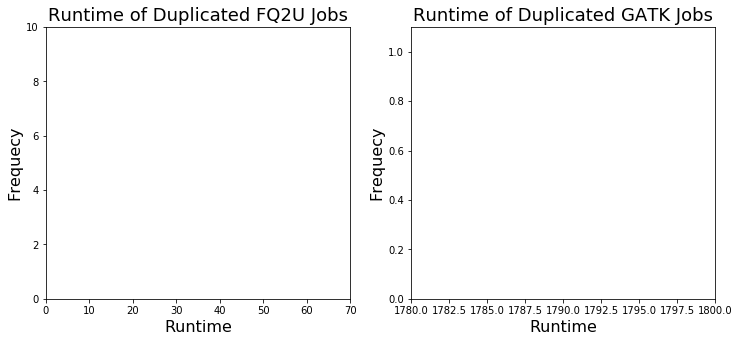

In [67]:
f, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.distplot(fq2u_dup.runtime, kde=False, ax=axes[0]).set(xlim=(0,70),ylim=(0,10));
axes[0].set_title('Runtime of Duplicated FQ2U Jobs', fontsize=18)
axes[0].set_ylabel('Frequecy', fontsize=16)
axes[0].set_xlabel('Runtime', fontsize=16)
plt.show

sns.distplot(gatk_dup.runtime, kde=False, ax=axes[1]).set(xlim=(1780,1800),ylim=(0,1.1));
axes[1].set_title('Runtime of Duplicated GATK Jobs', fontsize=18)
axes[1].set_ylabel('Frequecy', fontsize=16)
axes[1].set_xlabel('Runtime', fontsize=16)
plt.show

--------
## Runtime Analysis

### Distribution of FQ2U and GATK runtime 

In [71]:
## PASS case
fq2u_runtime_inpass=merged_df.loc[(merged_df['dstat_status']=='SUCCESS')&(merged_df['dup']!=True)&(merged_df['job']=='FQ2U'),'job_runtime']
gatk_runtime_inpass=merged_df.loc[(merged_df['pass']=='pass')&(merged_df['dup']!=True)&(merged_df['job']=='cromwell'),'job_runtime']/60
                                                                                        
## FAIL case                                                                               
fq2u_runtime_infail=merged_df.loc[(merged_df['dstat_status']!='SUCCESS')&(merged_df['dup']!=True)&(merged_df['job']=='FQ2U'),'job_runtime']
gatk_runtime_infail=merged_df.loc[(merged_df['pass']=='fail')&(merged_df['dup']!=True)&(merged_df['job']=='cromwell'),'job_runtime']/60                                                                                     

### Average of FQ2U and GATK runtime 

In [72]:
## PASS case
print("The average of FQ2U job runtime : " + str(fq2u_runtime_inpass.mean()) + " (min)")
print("The average of GATK job runtime : " + str(gatk_runtime_inpass.mean()) + " (hour)")
                                                                                        
## FAIL case                                                                               
print("The average of FQ2U job runtime in fail : " + str(fq2u_runtime_infail.mean()) + " (min)")
print("The average of GATK job runtime in fail : " + str(gatk_runtime_infail.mean()) + " (hour)")                                                                         

The average of FQ2U job runtime : 56.54757785467128 (min)
The average of GATK job runtime : 24.208652729384436 (hour)
The average of FQ2U job runtime in fail : nan (min)
The average of GATK job runtime in fail : nan (hour)


### Histogram of Runtime

<function matplotlib.pyplot.show(*args, **kw)>

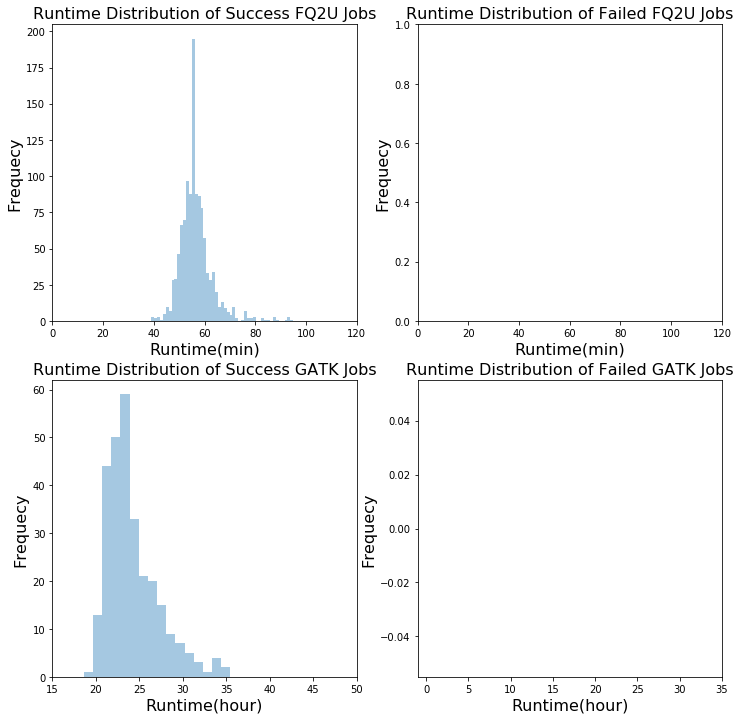

In [73]:
f, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.distplot(fq2u_runtime_inpass, kde=False, ax=axes[0,0]).set(xlim=(0,120))
axes[0,0].set_title('Runtime Distribution of Success FQ2U Jobs', fontsize=16)
axes[0,0].set_ylabel('Frequecy', fontsize=16)
axes[0,0].set_xlabel('Runtime(min)', fontsize=16)
plt.show

sns.distplot(fq2u_runtime_infail, kde=False, ax=axes[0,1]).set(xlim=(0,120),ylim=(0,1))
axes[0,1].set_title('Runtime Distribution of Failed FQ2U Jobs', fontsize=16)
axes[0,1].set_ylabel('Frequecy', fontsize=16)
axes[0,1].set_xlabel('Runtime(min)', fontsize=16)
plt.show

sns.distplot(gatk_runtime_inpass, kde=False, ax=axes[1,0]).set(xlim=(15,50))
axes[1,0].set_title('Runtime Distribution of Success GATK Jobs', fontsize=16)
axes[1,0].set_ylabel('Frequecy', fontsize=16)
axes[1,0].set_xlabel('Runtime(hour)', fontsize=16)
plt.show

sns.distplot(gatk_runtime_infail, kde=False, ax=axes[1,1], bins=20).set(xlim=(-1,35))
axes[1,1].set_title('Runtime Distribution of Failed GATK Jobs', fontsize=16)
axes[1,1].set_ylabel('Frequecy', fontsize=16)
axes[1,1].set_xlabel('Runtime(hour)', fontsize=16)
plt.show

--------
## Preemptable Analysis

### Add the retried VM count

In [77]:
merged_analysis_df=merged_df
merged_analysis_df['vm_added']=merged_df['vm_cnt']-merged_df['vm_exp_cnt']
# columnlist=['sample','pass','job','fq2urg_gatkid','dup','attempts','exp_vm','added_vm','runtime','unit_runtime','dstat_status','dstat_msg','dstat_log']
# merged_attemps_df=merged_attemps_df[columnlist]
merged_analysis_df.head(2)

,sample,pass,job_group,job,fq2urg_gatkid,dup,vm_exp_cnt,vm_cnt,vm_avg_runtime,job_runtime,...,vm_cpu,vm_mem,vm_disk,vm_avg_cost,job_cost,dstat_status,dstat_msg,dstat_log,added_vm,vm_added
0,SHIP5119453,fail,GATK,FQ2U,3,None,1.00,1,56.00,56.00,...,2,7680,None,0.00,0.09,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,0.00,0.00
1,SHIP5119453,fail,GATK,FQ2U,2,None,1.00,1,53.00,53.00,...,2,7680,None,0.00,0.09,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,0.00,0.00


### Extract GATK substeps

In [78]:
gatk_substeps_df=merged_analysis_df.loc[((merged_analysis_df['pass']=='pass')&(merged_analysis_df['dstat_status']=='SUCCESS')) \
                                        &(merged_analysis_df['job_group']!='QC') \
                                        &((merged_analysis_df['job']!='FQ2U')|(merged_analysis_df['job']!='GATK')),:]

### Retried VM count / initial VM count Ratio per GATK sub-job

In [82]:
added_vm_df=gatk_substeps_df[['job','vm_added','vm_exp_cnt']]
added_vm_mean_df=added_vm_df.groupby('job').mean()
added_vm_mean_df['vm_added_ratio']=100*(np.array(added_vm_mean_df['vm_added'])/np.array(added_vm_mean_df['vm_exp_cnt']))
display(added_vm_mean_df)

,vm_added,vm_exp_cnt,vm_added_ratio
job,,,
FQ2U,0.00,1.00,0.00
applybqsr,1.19,19.00,6.27
baserecalibrator,1.23,18.00,6.85
checkcontamination,0.07,1.00,7.32
converttocram,0.15,1.00,14.98
createsequencegroupingtsv,0.00,1.00,0.35
cromwell,0.00,1.00,0.00
gatherbamfiles,0.10,1.00,10.45
gatherbqsrreports,0.02,1.00,2.44


In [81]:
#len(np.array(added_vm_df['vm_added']))
#len(np.array(added_vm_df['vm_exp_cnt']))

In [88]:
added_vm_perc=added_vm_mean_df.loc[added_vm_mean_df['vm_added'].notnull(),'vm_added_ratio'].reset_index().sort_values('job',ascending=False)
#added_vm_perc.head()

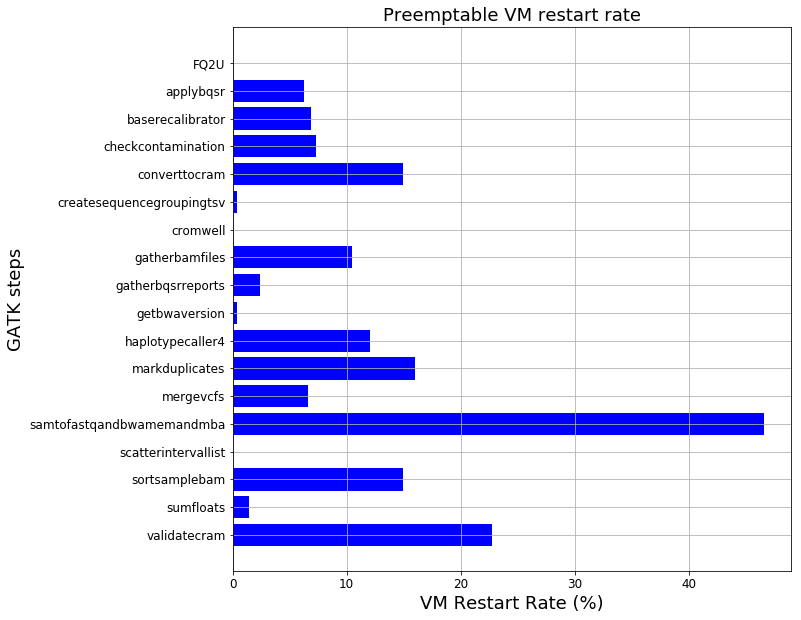

In [85]:
fig=plt.figure(figsize=(10, 10))
#ax.set_ylim(ax.get_ylim()[::-1])
plt.barh("job", "vm_added_ratio", data = added_vm_perc, color = "blue")
plt.xlabel("VM Restart Rate (%)", size=18)
#plt.xticks(rotation = 90)
plt.ylabel("GATK steps", size=18)
plt.title("Preemptable VM restart rate", size=18)
plt.tick_params(axis='both', labelsize=12)
plt.grid(True)
plt.show()

### Cases : if vm_cnt < vm_exp_cnt   <- Need to analysis

In [89]:
gatk_substeps_df.loc[merged_analysis_df['vm_cnt']<merged_analysis_df['vm_exp_cnt'],:]

,sample,pass,job_group,job,fq2urg_gatkid,dup,vm_exp_cnt,vm_cnt,vm_avg_runtime,job_runtime,...,vm_cpu,vm_mem,vm_disk,vm_avg_cost,job_cost,dstat_status,dstat_msg,dstat_log,added_vm,vm_added
4134,SHIP4962321,pass,GATK,baserecalibrator,f8cc6a97-85f5-4ac4-b5fd-3846ff8c8ba9,None,18.00,17,28.26,38.31,...,1,6144,None,0.00,0.10,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,-1.00,-1.00
4272,SHIP4946372,pass,GATK,samtofastqandbwamemandmba,a77303fd-ee14-4486-b55b-7649e583821f,None,4.00,3,185.67,191.85,...,16,14848,None,0.00,1.17,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,-1.00,-1.00
5784,SHIP5141893,pass,GATK,applybqsr,93ce723d-cdc4-435c-b7ab-afb039a543e8,None,19.00,18,24.41,42.73,...,1,3584,None,0.00,0.08,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,-1.00,-1.00


--------
## Validation Cram Analysis

In [ ]:
#vcram_df=job_df.loc[job_df['job']=='validatecram',['attempts','runtime','dstat_status']]

In [ ]:
# attempts_freq=vcram_df['attempts'].value_counts().to_frame()
# attempts_freq.reset_index(inplace=True)
# display(attempts_freq)
# plt.figure(figsize=(9,6))

# sns.barplot(x='index', y='attempts', data=attempts_freq)
# # sns.distplot(vcram_df.attempts, kde=False);
# plt.title('Histogram of attempts of validate cram jobs in GATK', fontsize=18)
# plt.ylabel('Number of jobs ', fontsize=16)
# plt.xlabel('Attempts for each validate cram job', fontsize=16)
# plt.show

In [ ]:
# vcram_df=job_df.loc[(job_df['job']=='validatecram') & (job_df['dstat_status']=='SUCCESS'),['attempts','runtime','dstat_status']]

In [ ]:
# sns.scatterplot(x="attempts", y="runtime",data=vcram_df).set

# # sns.distplot(vcram_df.attempts, kde=False);
# plt.title(' # of attemts and runtime of validate cram jobs in GATK', fontsize=18)
# plt.ylabel('runtime ', fontsize=16)
# plt.xlabel('Attempts for each validate cram job', fontsize=16)
# plt.show

In [ ]:
# attempts_freq=vcram_df['attempts'].value_counts().to_frame()
# attempts_freq.reset_index(inplace=True)
# display(attempts_freq)
# plt.figure(figsize=(9,6))

# sns.barplot(x='index', y='attempts', data=attempts_freq)
# # sns.distplot(vcram_df.attempts, kde=False);
# plt.title('Histogram of attempts of validate cram jobs in GATK', fontsize=18)
# plt.ylabel('Number of jobs ', fontsize=16)
# plt.xlabel('Attempts for each validate cram job', fontsize=16)
# plt.show

In [ ]:
# vcram_df=job_df.loc[(job_df['job']=='validatecram') & (job_df['dstat_status']=='FAILURE'),['attempts','runtime','dstat_status']]

In [ ]:
# sns.scatterplot(x="attempts", y="runtime",data=vcram_df)

# # sns.distplot(vcram_df.attempts, kde=False);
# plt.title(' # of attemts and runtime of validate cram jobs in GATK', fontsize=18)
# plt.ylabel('runtime ', fontsize=16)
# plt.xlabel('Attempts for each validate cram job', fontsize=16)
# plt.show

In [ ]:
# attempts_freq=vcram_df['attempts'].value_counts().to_frame()
# attempts_freq.reset_index(inplace=True)
# display(attempts_freq)
# plt.figure(figsize=(9,6))

# try:
#     sns.barplot(x='index', y='attempts', data=attempts_freq)
#     # sns.distplot(vcram_df.attempts, kde=False);
#     plt.title('Histogram of attempts of validate cram jobs in GATK', fontsize=18)
#     plt.ylabel('Number of jobs ', fontsize=16)
#     plt.xlabel('Attempts for each validate cram job', fontsize=16)
#     plt.show
# except:
#     print("no validatecram job with failed dstat message")

--------
## Cost

In [ ]:
#vmtype_cost_df=pd.read_excel("./VMtype_cost_min_v2.xlsx")
#vmtype_cost_min_df=vmtype_cost_df[['VMtype','Cost_min']]

In [ ]:
samples_cost=job_df.loc[(job_df['job']=='GATK') & (job_df['dstat_status']=='SUCCESS'),'sample']
pre_cost_df=job_df.loc[job_df['sample'].isin(samples_cost) ,['sample','job','attempts','runtime','unit_runtime','VMtype']]

merged_cost_df=pd.merge(vmtype_cost_min_df,pre_cost_df,left_on=['VMtype'],right_on=['VMtype'],how='right')
#merged_attemps_df['added_vm']=merged_attemps_df['attempts']-merged_attemps_df['exp_vm']
columnlist=['sample','job','attempts','runtime','unit_runtime','VMtype','Cost_min']
merged_cost_df=merged_cost_df[columnlist]

In [ ]:
pd.set_option('display.float_format', lambda x: '%.8f' % x)

## FQ2U
merged_cost_df.loc[merged_cost_df['job']=='FQ2U','cost']=np.array(merged_cost_df.loc[merged_cost_df['job']=='FQ2U','runtime'])*np.array(merged_cost_df.loc[merged_cost_df['job']=='FQ2U','Cost_min'])
#merged_cost_df.head(2)

## GATK
merged_cost_df.loc[merged_cost_df['job']=='GATK','cost']=np.array(merged_cost_df.loc[merged_cost_df['job']=='GATK','runtime'])*np.array(merged_cost_df.loc[merged_cost_df['job']=='GATK','Cost_min'])
#merged_cost_df[merged_cost_df['job']=='GATK'].head(2)

## GATK steps
merged_cost_df.loc[(merged_cost_df['job']!='FQ2U') & (merged_cost_df['job']!='GATK'),'cost']=np.array(merged_cost_df.loc[(merged_cost_df['job']!='FQ2U') & (merged_cost_df['job']!='GATK'),'attempts']) \
*np.array(merged_cost_df.loc[(merged_cost_df['job']!='FQ2U') & (merged_cost_df['job']!='GATK'),'unit_runtime'])*np.array(merged_cost_df.loc[(merged_cost_df['job']!='FQ2U') & (merged_cost_df['job']!='GATK'),'Cost_min'])

In [ ]:
merged_cost_df.sort_values(['sample','job'],inplace=True)
merged_cost_df.to_csv('cost_df_v058-1.csv')

### Total cost by sample

In [90]:
samples_cost=job_df.loc[(job_df['job']=='cromwell') & (job_df['dstat_status']=='SUCCESS'),'sample']
success_job_df=job_df.loc[job_df['sample'].isin(samples_cost), : ]

In [92]:
cost_by_sample=success_job_df.groupby('sample')['job_cost'].sum().reset_index()
print('The avarage total cost per sample : ' + str(cost_by_sample['job_cost'].mean()))

The avarage total cost per sample : 6.434837582479933


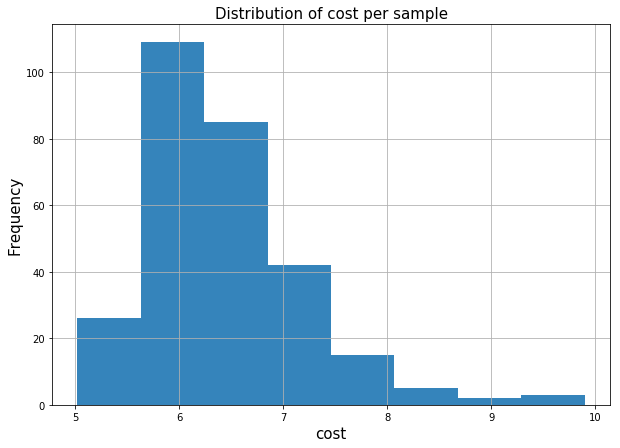

In [94]:
fig, ax = plt.subplots(figsize=(10,7))
hist = cost_by_sample.job_cost.hist(alpha=0.9, ax=ax, bins=8)
#ax.set_xlim(1.9,2.0)
ax.set_title("Distribution of cost per sample",size=15)
ax.set_xlabel("cost",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### Total cost by sample (with QC)

In [104]:
mean_num_FQ2U_bysample=success_job_df.groupby(['sample','job']).count().reset_index()
FQ2U_num=mean_num_FQ2U_bysample.loc[mean_num_FQ2U_bysample['job']=='FQ2U','job_cost'].mean()

In [105]:
cost_by_job=success_job_df.groupby('job')['job_cost'].mean().reset_index()
cost_by_job.loc[cost_by_job['job']=='FQ2U','job_cost']=np.array(cost_by_job.loc[cost_by_job['job']=='FQ2U','job_cost'])*FQ2U_num
cost_by_job.loc[cost_by_job['job']=='GATK','job_cost']='Cromwell'
cost_by_job.head(20)

#cost_by_job.sort_values('cost',ascending=False, inplace=True)
#cost_by_job.head(20)

,job,job_cost
0,FQ2U,0.38
1,applybqsr,0.10
2,bam-fastqc,0.11
3,baserecalibrator,0.12
4,checkcontamination,0.02
5,converttocram,0.02
6,createsequencegroupingtsv,0.00
7,cromwell,2.93
8,flagstat,0.02
9,gatherbamfiles,0.03


In [106]:
# from matplotlib import style
# import matplotlib as mpl
# style.use('ggplot')

# fig = plt.figure(1, figsize=(12,12))
# labels = cost_by_job['job']
# #label_only = [cost_by_job['job'][0],cost_by_job['job'][1],'','','','','','','','','',cost_by_job['job'][11],'','','',cost_by_job['job'][15],'','','','','']
# #colors = ['red','grey']
# ratio = cost_by_job['cost']
# patches, texts, autotexts=plt.pie(ratio, labels=labels, autopct='%.1f%%', shadow=False, startangle=20, textprops={'fontsize': 18})

# for i in range(len(labels)):
#     texts[i].set_fontsize(18)
# # texts[1].set_fontsize(20)
# # texts[11].set_fontsize(20)
# # texts[15].set_fontsize(20)

# plt.legend(patches, labels, loc="center right", bbox_to_anchor=(-0.1, 1.), fontsize=15)
# plt.show()
# #plt.savefig('./success_rate.png')

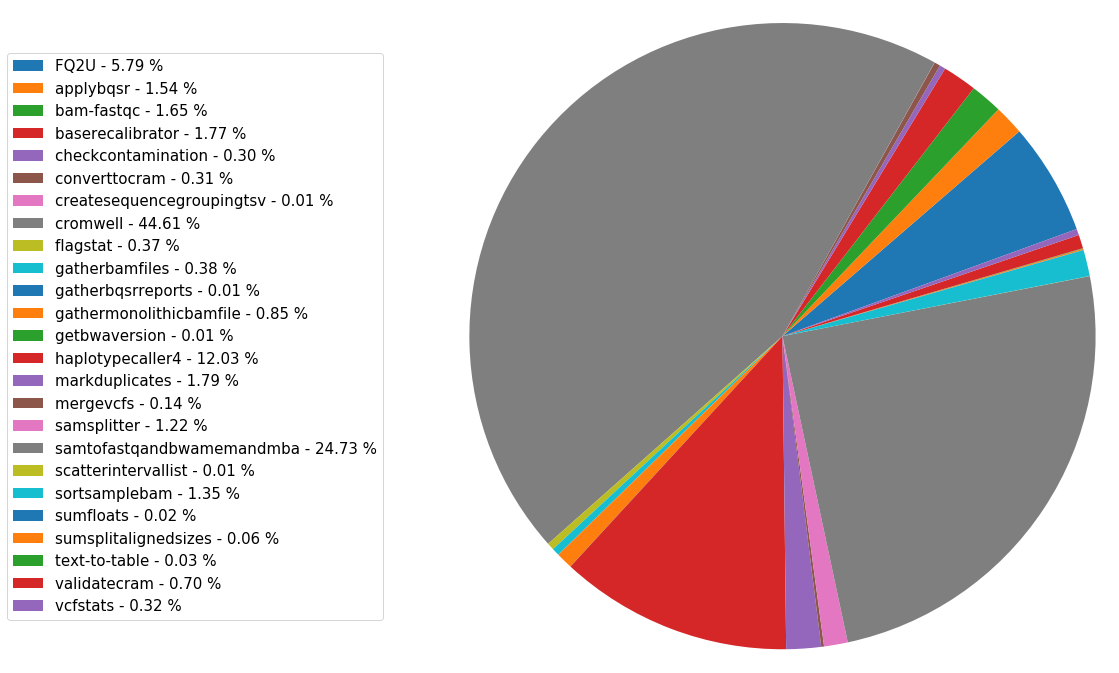

In [107]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(1, figsize=(12,12))
x = np.char.array(cost_by_job['job'].to_list())
y = np.array(cost_by_job['job_cost'])
#colors = ['yellowgreen','red','gold','lightskyblue','white','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, startangle=20, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.7, 0.5),
           fontsize=15)

--------
## Log Analysis (Temp)

In [ ]:
# issued_log=sample_analysis_df.loc[(sample_analysis_df['status']=='success') & (sample_analysis_df['dstat_failed']=='GATK'),['sample','log']]

In [ ]:
# issued_log.reset_index(inplace=True)
# display(issued_log.count())
# display(issued_log.head(22))

In [ ]:
# f = open("./issued_log_success_v058-1.txt", 'w')
# for s, i in enumerate(issued_log['log']):
#     i = i + '/*out.log'
#     try:
#         f.write(str(issued_log['sample'][s])+'\n')
#         f.write(str(subprocess.check_output('gsutil cat ' + i + '| grep "failed"', shell=True),'utf-8'))
#         f.write('\n')
#     except:
#         continue
# f.close()

# for log in success_issued_log['log'][0:1]:
#     log = log + '/*out.log'
#     print(log)
#     !gsutil cat gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000398/SHIP4946378/gatk-5-dollar/200202-230755-888-c8678bdf/logs/*[0-9].log | grep 'error'


In [ ]:
# failed_log=sample_analysis_df.loc[(sample_analysis_df['pass']=='fail'),['sample','log']]

In [ ]:
# failed_log.reset_index(inplace=True)
# display(failed_log.count())
# display(failed_log.head(22))

In [ ]:
# f = open("./failed_log_success_v058-1.txt", 'w')
# for s, i in enumerate(failed_log['log']):
#     try:
#         i = i + '/*out.log'
#         f.write(str(failed_log['sample'][s])+'\n')
#         f.write(str(subprocess.check_output('gsutil cat ' + i + '| grep "failed"', shell=True),'utf-8'))
#         f.write('\n')
#     except:
#         continue
# f.close()

# for log in success_issued_log['log'][0:1]:
#     log = log + '/*out.log'
#     print(log)
#     !gsutil cat gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000398/SHIP4946378/gatk-5-dollar/200202-230755-888-c8678bdf/logs/*[0-9].log | grep 'error'
